In [1]:
import os 
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [5]:
! pip install gdown

In [6]:
! gdown https://drive.google.com/uc?id=1lN8swb1sdt3rcqAltRH5lCLqUzUGrU47

Downloading...
From: https://drive.google.com/uc?id=1lN8swb1sdt3rcqAltRH5lCLqUzUGrU47
To: /content/resized.zip
648MB [00:03, 164MB/s]


In [7]:
# https://drive.google.com/file/d/1lN8swb1sdt3rcqAltRH5lCLqUzUGrU47/view?usp=sharing

In [8]:
! unzip resized.zip > /dev/null

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import lxml.etree as ET
from bs4 import BeautifulSoup
import os
import spacy
import string
import re
from tqdm.notebook import tqdm
import math
import numpy as np
from spacy.symbols import ORTH
from pathlib import Path
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import cv2
import matplotlib.pyplot as plt

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### GDrive Path

In [11]:
grootpath = Path('/content/gdrive/My Drive/Colab Notebooks/deep_learning/DoggyGANs')

In [12]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [13]:
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(center_crop_square(im), (sz, sz))

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = np.random.uniform(0, 1)
    rand_c = np.random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [14]:
train_df = pd.read_csv(grootpath/'generative-dog-images/files.csv')
train_df.head()

,f_name,f_subname,label
0,generative-dog-images/resized/n02109961_16718.jpg,n02109961_16718,Eskimo_dog
1,generative-dog-images/resized/n02113799_5009.jpg,n02113799_5009,standard_poodle
2,generative-dog-images/resized/n02091032_6587.jpg,n02091032_6587,Italian_greyhound
3,generative-dog-images/resized/n02106166_1429.jpg,n02106166_1429,Border_collie
4,generative-dog-images/resized/n02093754_2276.jpg,n02093754_2276,Border_terrier


In [15]:
gimage_path = Path(grootpath/'generative-dog-images/resized/')
train_df['g_name'] = train_df['f_name'].apply(lambda x: str(gimage_path) + '/' + x.split('/')[-1])
train_df.head()

,f_name,f_subname,label,g_name
0,generative-dog-images/resized/n02109961_16718.jpg,n02109961_16718,Eskimo_dog,/content/gdrive/My Drive/Colab Notebooks/deep_...
1,generative-dog-images/resized/n02113799_5009.jpg,n02113799_5009,standard_poodle,/content/gdrive/My Drive/Colab Notebooks/deep_...
2,generative-dog-images/resized/n02091032_6587.jpg,n02091032_6587,Italian_greyhound,/content/gdrive/My Drive/Colab Notebooks/deep_...
3,generative-dog-images/resized/n02106166_1429.jpg,n02106166_1429,Border_collie,/content/gdrive/My Drive/Colab Notebooks/deep_...
4,generative-dog-images/resized/n02093754_2276.jpg,n02093754_2276,Border_terrier,/content/gdrive/My Drive/Colab Notebooks/deep_...


In [16]:
train_df['colab_path'] = train_df['f_subname'].apply(lambda x: f"resized/{x}.jpg")
train_df.head()

,f_name,f_subname,label,g_name,colab_path
0,generative-dog-images/resized/n02109961_16718.jpg,n02109961_16718,Eskimo_dog,/content/gdrive/My Drive/Colab Notebooks/deep_...,resized/n02109961_16718.jpg
1,generative-dog-images/resized/n02113799_5009.jpg,n02113799_5009,standard_poodle,/content/gdrive/My Drive/Colab Notebooks/deep_...,resized/n02113799_5009.jpg
2,generative-dog-images/resized/n02091032_6587.jpg,n02091032_6587,Italian_greyhound,/content/gdrive/My Drive/Colab Notebooks/deep_...,resized/n02091032_6587.jpg
3,generative-dog-images/resized/n02106166_1429.jpg,n02106166_1429,Border_collie,/content/gdrive/My Drive/Colab Notebooks/deep_...,resized/n02106166_1429.jpg
4,generative-dog-images/resized/n02093754_2276.jpg,n02093754_2276,Border_terrier,/content/gdrive/My Drive/Colab Notebooks/deep_...,resized/n02093754_2276.jpg


## Dataset

In [17]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

### Label to Index

In [18]:
label2index = {val:i for i, val in enumerate(sorted(set(train_df['label'])))}

In [19]:
class DogsDataset(Dataset):
    def __init__(self, df, transforms=False, colab=True):
        self.df = df
        self.transforms = transforms
        if colab: self.files = np.array(df['colab_path'])
        else: self.files = np.array(df['f_name'])
        self.y = np.array(df['label'].map(label2index))
        self.items = df.shape[0]
        self.random_init()
        
    def random_init(self):
        self.random = np.random.rand(self.items, 4)

    def transform(self, x):
        rdeg = (np.random.random()-0.5)*20
        x = rotate_cv(x, rdeg)
        x = random_crop(x)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
        return x

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        path = str(self.files[idx])
        x = cv2.imread(path).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            x = self.transform(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), self.y[idx]

In [20]:
assert cv2.imread(train_df['colab_path'][0]) is not None

## Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df, test_size=0.2)

train_ds = DogsDataset(train, transforms=True)
valid_ds = DogsDataset(val, transforms=False)

In [22]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [23]:
next(iter(train_dl))

[tensor([[[[-1.0730, -1.0393, -0.9968,  ..., -0.7740, -0.7783, -0.7902],
           [-1.0829, -1.0513, -1.0338,  ..., -0.6955, -0.7428, -0.7683],
           [-1.0433, -1.0124, -1.0091,  ..., -0.6880, -0.6939, -0.7073],
           ...,
           [-0.9913, -0.9062, -0.9280,  ..., -0.5290, -0.6518, -0.7051],
           [-1.0022, -0.9339, -0.9513,  ..., -0.6822, -0.7209, -0.7291],
           [-1.0630, -0.9836, -0.9290,  ..., -0.7669, -0.7756, -0.7636]],
 
          [[-0.8450, -0.8105, -0.7670,  ..., -0.4422, -0.4386, -0.4508],
           [-0.8551, -0.8227, -0.8049,  ..., -0.3786, -0.4023, -0.4284],
           [-0.8146, -0.7830, -0.7796,  ..., -0.3375, -0.3425, -0.3550],
           ...,
           [-0.7073, -0.6274, -0.6491,  ..., -0.4623, -0.5994, -0.6560],
           [-0.7161, -0.6502, -0.6680,  ..., -0.6023, -0.6529, -0.6484],
           [-0.7937, -0.7130, -0.6578,  ..., -0.6610, -0.6725, -0.6577]],
 
          [[-0.4796, -0.4452, -0.4019,  ..., -0.0852, -0.0645, -0.0981],
           [-

## Resnet Model

In [24]:
resnet = models.resnet34(pretrained=True)
#resnet

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [25]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [26]:
len(layers)

10

In [27]:
class DogClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DogClassifier, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, num_classes))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [28]:
# num_classes = len(label2index)
# model = DogClassifier(num_classes).cuda()

## Learning Rate Finder

In [29]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr)#, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr[i]

In [30]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, optimizer, train_ds, train_dl, lr_low=1e-4, lr_high=0.1, epochs=1):
    losses = []
    p = grootpath/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    pbar = tqdm(total=iterations)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        train_ds.random_init()
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.float().cuda()
            y = y.long().cuda()
            # x, y = normalize_tensors(x, y)
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            # with amp.scale_loss(loss, optimizer) as scaled_loss:
            #     scaled_loss.backward()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            pbar.update()
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [31]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/10, max_lr/100
    iter1 = int(0.2*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

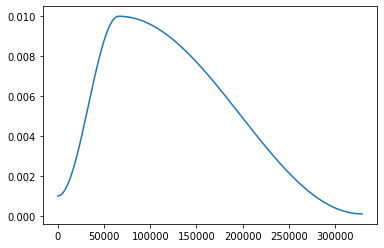

In [32]:
N = len(train_ds)*20
lr = get_cosine_triangular_lr(0.01, N)
plt.plot(list(range(N)), lr)
plt.show()

In [33]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in valid_dl:
            x = x.float().cuda()
            y = y.long().cuda()
            # x, y = normalize_tensors(x, y)
            batch = y.shape[0]
            out = model(x)
            pred = torch.max(out, 1)[1]
            loss = F.cross_entropy(out, y)
            sum_loss += batch*(loss.item())
            total += batch
            correct += (pred == y).float().sum().item()
    
    return sum_loss/total, correct/total

In [34]:
def train_epoch(model, train_ds, train_dl, optimizer, lrs, idx, epoch, pbar):
    model.train()
    train_ds.random_init()
    total = 0
    sum_loss = 0
    for x,y in train_dl:
        lr = lrs[idx]
        x = x.float().cuda()
        y = y.long().cuda()
        update_optimizer(optimizer, [lr/4, lr/2, lr])
        # x, y = normalize_tensors(x, y)
        batch = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        optimizer.zero_grad()
        ## mixed precision
        # with amp.scale_loss(loss, optimizer) as scaled_loss:
        #     scaled_loss.backward()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.update()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    train_loss = sum_loss/total
    return train_loss, idx

In [35]:
def train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr, epochs = 60, fixed_lr=False):
    
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    best_val_acc = 0.0
    idx = 0
    stats = []
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    if fixed_lr:
        lrs = [max_lr for i in range(iterations)]
    for i in range(epochs):
        print("using lr ", i, lrs[idx], idx)
        train_loss, idx = train_epoch(model, train_ds, train_dl, optimizer, lrs, idx, i, pbar)
        val_loss, val_acc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f \n" % 
              (train_loss, val_loss, val_acc))
        stats.append((idx, train_loss, val_loss, val_acc))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            path = "{0}/models/model_imagenet4_acc_{1:.0f}.pth".format(grootpath, 100*val_acc) 
            save_model(model, path)
            print(path)
    return stats

In [36]:
num_classes = len(label2index)
model = DogClassifier(num_classes).cuda()
optimizer = get_optimizer(model)
# optimizer = optim.LBFGS([img], optim_state)
# optimizer = optim.Adam([img], optim_state)
# lrs, losses = LR_range_finder(model, optimizer, train_ds, train_dl)
stats = train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr=0.1, epochs = 50, fixed_lr=False)

using lr  0 0.009999999999999995 0
train_loss 5.160 val_loss 12.120 val_acc 0.020 

/content/gdrive/My Drive/Colab Notebooks/deep_learning/DoggyGANs/models/model_imagenet4_acc_2.pth
using lr  1 0.012202456766718078 515
train_loss 4.583 val_loss 5.139 val_acc 0.049 

/content/gdrive/My Drive/Colab Notebooks/deep_learning/DoggyGANs/models/model_imagenet4_acc_5.pth
using lr  2 0.018594235253127367 1030
train_loss 4.222 val_loss 4.434 val_acc 0.054 

/content/gdrive/My Drive/Colab Notebooks/deep_learning/DoggyGANs/models/model_imagenet4_acc_5.pth
using lr  3 0.02854966364683871 1545
train_loss 4.032 val_loss 4.511 val_acc 0.080 

/content/gdrive/My Drive/Colab Notebooks/deep_learning/DoggyGANs/models/model_imagenet4_acc_8.pth
using lr  4 0.041094235253127366 2060
train_loss 3.901 val_loss 4.395 val_acc 0.073 

using lr  5 0.055 2575
train_loss 3.810 val_loss 11.570 val_acc 0.084 

/content/gdrive/My Drive/Colab Notebooks/deep_learning/DoggyGANs/models/model_imagenet4_acc_8.pth
using lr  6 

In [37]:
grootpath

PosixPath('/content/gdrive/My Drive/Colab Notebooks/deep_learning/DoggyGANs')

In [40]:
torch.save(model, grootpath/'ResnetClassifier.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DogClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [44]:
model_stats = pd.DataFrame({'idx': [val[0] for val in stats],
                            'train_loss': [val[1] for val in stats],
                            'val_loss': [val[2] for val in stats],
                            'val_accuracy': [val[3] for val in stats]})

model_stats.to_csv(grootpath/"resnet_model_stats.csv")